In [1]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Image directories
nickels_cropped_dir = "./nickels_cropped/"
nickels_cropped_files = glob(f"{nickels_cropped_dir}/*")

quarters_cropped_dir = "./quarters_cropped/"
quarters_cropped_files = glob(f"{quarters_cropped_dir}/*")

cents_cropped_dir = "./cents_cropped/"
cents_cropped_files = glob(f"{cents_cropped_dir}/*")

In [3]:
def calculate_moments(image):
    mean = np.mean(image)
    std_dev = np.std(image)
    
    if std_dev == 0:
        skewness = 0
        kurtosis = 0
    else:
        skewness = np.mean((image - mean) ** 3) / (std_dev ** 3)
        kurtosis = np.mean((image - mean) ** 4) / (std_dev ** 4) - 3
    
    return mean, std_dev, skewness, kurtosis

In [4]:
def create_ring_masks_const(image, num_rings):
    p = num_rings
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    masks = []

    for i in range(num_rings):
        area_ratio = (i + 1) / num_rings
        radius_outer = int(np.sqrt(area_ratio) * min(height/p, width/p))

        if i == 0:
            radius_inner = 0
        else:
            area_ratio_prev = i / num_rings
            radius_inner = int(np.sqrt(area_ratio_prev) * min(height/(p+1), width/(p+1)))

        mask = np.zeros_like(image, dtype = np.uint8)
        cv2.circle(mask, center, radius_outer, (255, 255, 255), thickness = -1)
        cv2.circle(mask, center, radius_inner, (0, 0, 0), thickness = -1)

        masks.append(mask)
        p -= 1

    return masks

def create_ring_masks_with_growth_factor(image, num_rings, growth_rate = 0.8, inner_outer_ratio = 0.5):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    masks = []

    for i in range(num_rings):
        adjusted_growth_rate = growth_rate ** i
        radius_ratio = inner_outer_ratio + (1 - inner_outer_ratio) * (i / num_rings)
        radius_outer = int(adjusted_growth_rate * radius_ratio * min(height, width))

        radius_inner = int(radius_outer * inner_outer_ratio)

        mask = np.zeros_like(image, dtype = np.uint8)
        cv2.circle(mask, center, radius_outer, (255, 255, 255), thickness = -1)
        cv2.circle(mask, center, radius_inner, (0, 0, 0), thickness = -1)

        masks.append(mask)

    return masks

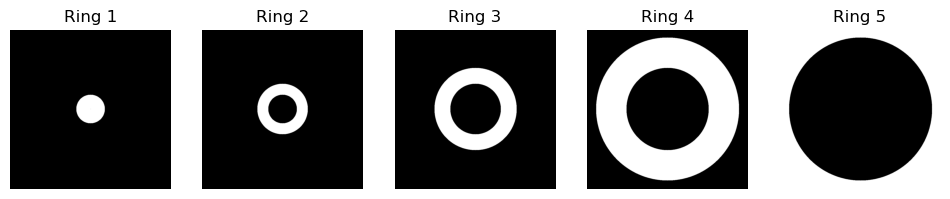

In [5]:
image = cv2.imread(nickels_cropped_files[0])
num_rings = 5
ring_masks = create_ring_masks_const(image, num_rings)

plt.figure(figsize = (12, 4))

for i, mask in enumerate(ring_masks, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

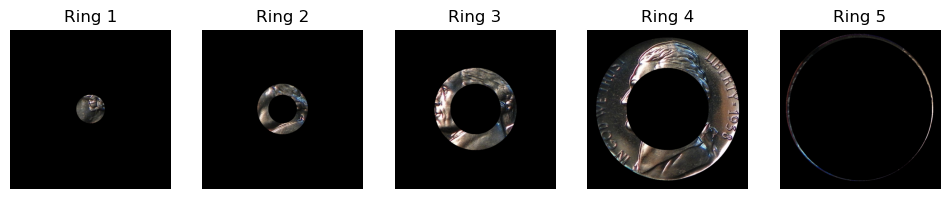

In [6]:
cropped_imgs = []
for mask in ring_masks:
    cropped = cv2.bitwise_and(image, image, mask = mask[:, :, 0])
    cropped_imgs.append(cropped)

plt.figure(figsize = (12, 4))

for i, cropped in enumerate(cropped_imgs, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

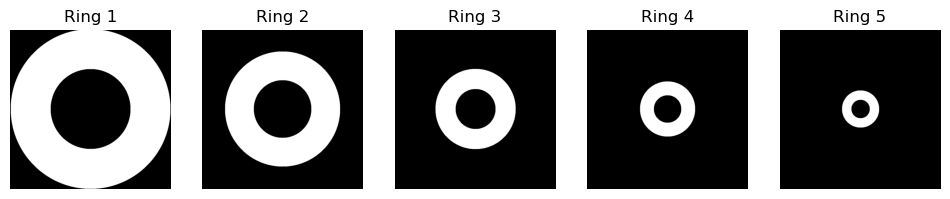

In [7]:
image = cv2.imread(nickels_cropped_files[0])
num_rings = 5
ring_masks = create_ring_masks_with_growth_factor(image, num_rings, growth_rate = 0.6)

plt.figure(figsize = (12, 4))
for i, mask in enumerate(ring_masks, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

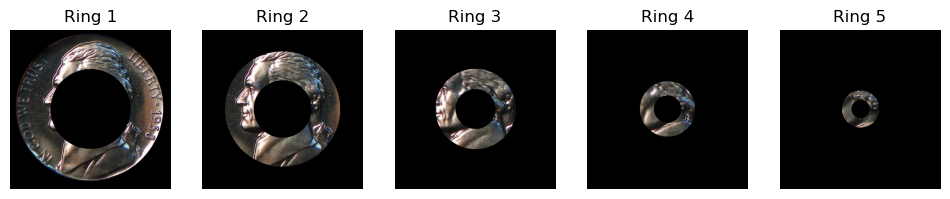

In [8]:
cropped_imgs = []
for mask in ring_masks:
    cropped = cv2.bitwise_and(image, image, mask = mask[:, :, 0])
    cropped_imgs.append(cropped)

plt.figure(figsize = (12, 4))

for i, cropped in enumerate(cropped_imgs, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

In [9]:
def extract_shape_features(image, ring_masks):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute gradient using Sobel operators
    gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute gradient magnitude and orientation
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)
    
    # Normalize gradient magnitude to [0, 1]
    normalized_gradient = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude))
    
    shape_features = []
    for ring_mask in ring_masks:
        #ring_mask = (radius - 1 < normalized_gradient) & (normalized_gradient <= radius)
        mask = ring_mask[:, :, 0]
        ring_magnitudes = gradient_magnitude[ring_mask]
        ring_orientations = gradient_orientation[ring_mask]
        
        if len(ring_magnitudes) > 0:
            feature = calculate_moments(ring_magnitudes)
            shape_features += feature
    
    return shape_features

In [48]:
def apply_adaptive_histogram_equalization(image, clip_limit = 1.5, tile_size = (8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_image, (15, 15), 0)

    clahe = cv2.createCLAHE(clipLimit = clip_limit, 
                            tileGridSize = tile_size)
    equalized_image = clahe.apply(blur_img)
    
    return equalized_image

29.475105703446488
16.55294535724685


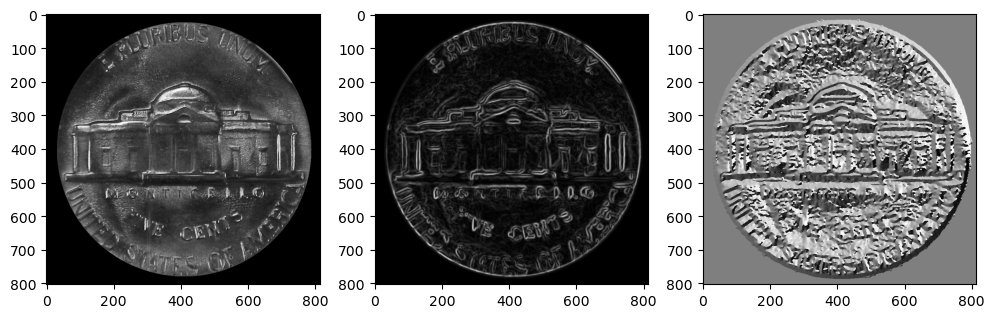

In [49]:
image = cv2.imread(nickels_cropped_files[90])
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
equalized_img = apply_adaptive_histogram_equalization(image, tile_size = (3, 3))

# Compute gradient using Sobel operators
gradient_x = cv2.Sobel(equalized_img, cv2.CV_64F, 1, 0, ksize = 3)
gradient_y = cv2.Sobel(equalized_img, cv2.CV_64F, 0, 1, ksize = 3)

# Compute gradient magnitude and orientation
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_orientation = np.arctan2(gradient_y, gradient_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))
ax1.imshow(gray_image, cmap = 'gray')
ax2.imshow(gradient_magnitude, cmap = 'gray')
ax3.imshow(gradient_orientation, cmap = 'gray')

print(np.mean(gradient_magnitude))
print(np.median(gradient_magnitude))

In [25]:
image = cv2.imread("./test/test_img5.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute gradient using Sobel operators
gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = 3)
gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = 3)

# Compute gradient magnitude and orientation
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_orientation = np.arctan2(gradient_y, gradient_x)

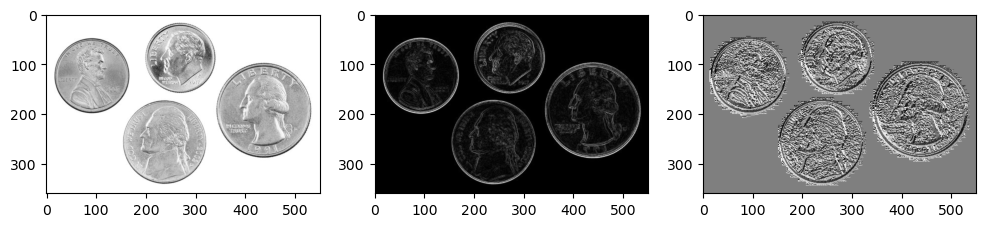

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))
ax1.imshow(gray_image, cmap = 'gray')
ax2.imshow(gradient_magnitude, cmap = 'gray')
ax3.imshow(gradient_orientation, cmap = 'gray')

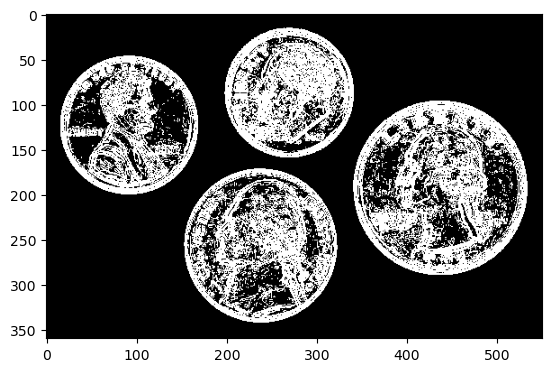

In [33]:
magnitude_threshold = 50
edges = (gradient_magnitude > magnitude_threshold).astype(np.uint8) * 255
plt.imshow(edges, cmap = 'gray')

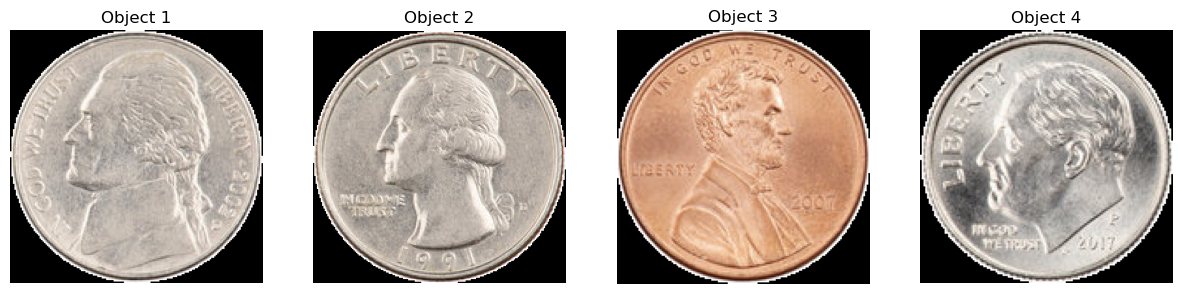

In [35]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


fig, axs = plt.subplots(1, len(contours), figsize=(15, 5))

for i, (contour, ax) in enumerate(zip(contours, axs)):
    mask = np.zeros_like(edges)
    cv2.drawContours(mask, [contour], 0, (255), thickness = cv2.FILLED)
    object_cropped = cv2.bitwise_and(image, image, mask = mask)

    x, y, w, h = cv2.boundingRect(contour)
    object_cropped = object_cropped[y:y+h, x:x+w]

    ax.imshow(cv2.cvtColor(object_cropped, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Object {i+1}')
    ax.axis('off')

plt.show()

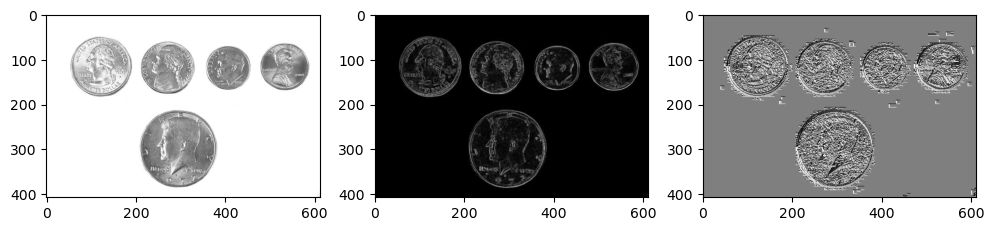

In [38]:
image = cv2.imread("./test/test_img16.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute gradient using Sobel operators
gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = 3)
gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = 3)

# Compute gradient magnitude and orientation
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_orientation = np.arctan2(gradient_y, gradient_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))
ax1.imshow(gray_image, cmap = 'gray')
ax2.imshow(gradient_magnitude, cmap = 'gray')
ax3.imshow(gradient_orientation, cmap = 'gray')

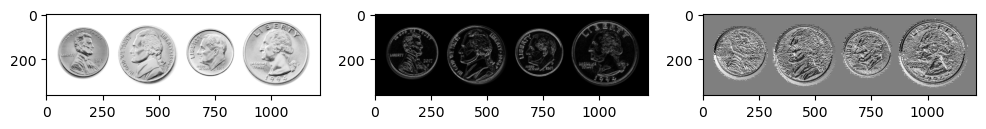

In [39]:
image = cv2.imread("./test/test_img4.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute gradient using Sobel operators
gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = 3)
gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = 3)

# Compute gradient magnitude and orientation
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_orientation = np.arctan2(gradient_y, gradient_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))
ax1.imshow(gray_image, cmap = 'gray')
ax2.imshow(gradient_magnitude, cmap = 'gray')
ax3.imshow(gradient_orientation, cmap = 'gray')

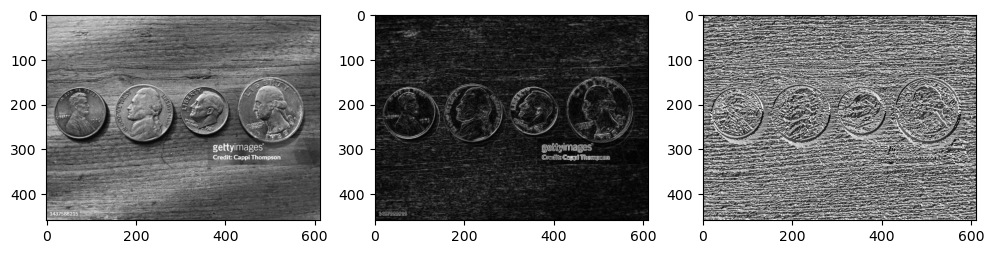

In [40]:
image = cv2.imread("./test/test_img10.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute gradient using Sobel operators
gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = 3)
gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = 3)

# Compute gradient magnitude and orientation
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_orientation = np.arctan2(gradient_y, gradient_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))
ax1.imshow(gray_image, cmap = 'gray')
ax2.imshow(gradient_magnitude, cmap = 'gray')
ax3.imshow(gradient_orientation, cmap = 'gray')